# Differential Settlement Interpolator
This program takes an input of the survey measurements `differential_settlement_measurements.csv` at survey radials of a tank, and the nodes `differential_settlement_nodes.csv` from an FEA model of the tank.  The program outputs the nodal displacement values for nodes in an FEA model.  The values are interpolated with a cubic function and placed into `differential_settlement_nodal_displacements.csv`.

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from helper import aiken_plot_defaults

Import the data

In [2]:
measurements_path = "data/differential_settlement_measurements.csv"
nodes_path = "data/differential_settlement_nodes.csv"
head = os.path.split(os.path.split(os.getcwd())[0])[0]

meaurements = pd.read_csv(os.path.join(head, measurements_path))
nodes = pd.read_csv(os.path.join(head, nodes_path))

In [3]:
meaurements

,radial,angle,disp
0,1,0,0.00
1,2,45,0.00
2,3,90,0.72
3,4,135,1.92
4,5,180,3.96
5,6,225,5.16
6,7,270,3.84
7,8,315,1.92


In [4]:
nodes.describe()

,NODE,R,aa,Angle,Z
count,128.000000,128.0,128.000000,128.000000,128.0
mean,2469.445312,276.0,1.405844,181.405844,0.0
std,1642.137990,0.0,104.328106,104.328106,0.0
min,1.000000,276.0,-177.190000,2.810000,0.0
25%,730.750000,276.0,-87.890250,92.109750,0.0
50%,2158.500000,276.0,1.406250,181.406250,0.0
75%,3586.250000,276.0,90.703250,270.703250,0.0
max,5015.000000,276.0,180.000000,360.000000,0.0


In [5]:
m_radials = meaurements["radial"].to_numpy()
m_angles = meaurements["angle"].to_numpy()
m_displacements = meaurements["disp"].to_numpy()
node_angles = nodes["Angle"].to_numpy()

Add cycles to the measurement.  This has two effects:
1. The cubic interpolation will be more smooth at the end points.
2. The range of angles for the measurements will overlap the range of angles for the nodes.

In [6]:
m_angles = np.append(np.append(m_angles - 360, m_angles), m_angles + 360)
m_displacements = np.append(np.append(m_displacements, m_displacements), m_displacements)


Interpolate the data to develop nodal displacement

In [7]:
displacement_interpolation = interp1d(m_angles, m_displacements, kind='cubic')

In [8]:
nodal_displacements = displacement_interpolation(node_angles)

Plot the data

In [9]:
title = "Nodal Displacements for Differential Settlement"
x_label = "Angle"
y_label = "Displacement"

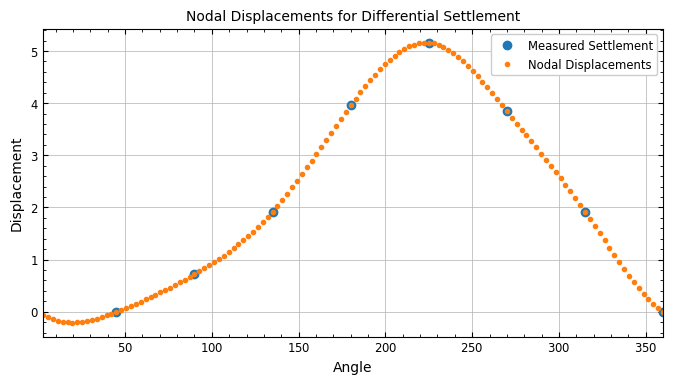

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(m_angles, m_displacements, 'o', label="Measured Settlement")
ax.plot(node_angles, nodal_displacements, '.', label="Nodal Displacements")
plt.xlim(min(node_angles), max(node_angles))
plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.show()

Output the nodal displacements to a file

In [11]:
node_disp_path = "data/differential_settlement_node_disp.csv"
nodes.insert(2,'Disp', nodal_displacements)
nodes.to_csv(os.path.join(head, node_disp_path), mode="w", index=False, header=True)